In [5]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Conectar a la base de datos
conn = sqlite3.connect("pipeline.db")

# Cargar la tabla limpia de ODEPA
df = pd.read_sql("SELECT * FROM ODEPA_PRECIOS_CLEAN", conn)

# Asegurarse de que no haya valores nulos críticos
df = df.dropna(subset=["Region", "Grupo", "Precio promedio"])

# --- OPCIÓN 1: Boxplot por región ---
plt.figure(figsize=(12, 6))
sns.boxplot(x="Region", y="Precio promedio", data=df)
plt.xticks(rotation=45)
plt.title("Dispersión de precios por Región (todos los grupos)")
plt.ylabel("Precio promedio (CLP)")
plt.xlabel("Region")
plt.tight_layout()
plt.show()

# --- OPCIÓN 2: Boxplot por grupo, separados por región ---
plt.figure(figsize=(14, 6))
sns.boxplot(x="Grupo", y="Precio promedio", hue="Region", data=df)
plt.xticks(rotation=45)
plt.title("Dispersión de precios por Grupo de alimento y Region")
plt.ylabel("Precio promedio (CLP)")
plt.xlabel("Grupo de alimento")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

DatabaseError: Execution failed on sql 'SELECT * FROM ODEPA_PRECIOS_CLEAN': no such table: ODEPA_PRECIOS_CLEAN

BRFSS table detected: BRFSS_2024_LIMPIO
NHANES table detected: NHANES_LIMPIO

BRFSS cargado: 457,670 filas
NHANES cargado: 11,933 filas

Columnas detectadas (BRFSS):
  MEDCOST: MEDCOST1
  DIABETES: tiene_diabetes
  ESTADO: _STATE

Top 10 estados por % que no pudo pagar (BRFSS):
     _STATE  n_obs  pct_no_pudo  prev_diab
      Texas  11996    15.035392  15.871957
Mississippi   2887    12.893503  16.626256
  Louisiana   4369    12.601715  19.272145
 New Jersey   8393    12.589430  13.046586
   Oklahoma   6848    12.416820  17.800818
     Nevada   2566    12.321563  14.107560
    Georgia   7067    12.117874  18.225555
   Colorado  10635    12.049188  10.625294
   Illinois  11683    11.936561  15.167337
   Arkansas   5254    11.283683  19.832509

Correlación Pearson (pct_no_pudo vs prev_diab): 0.153


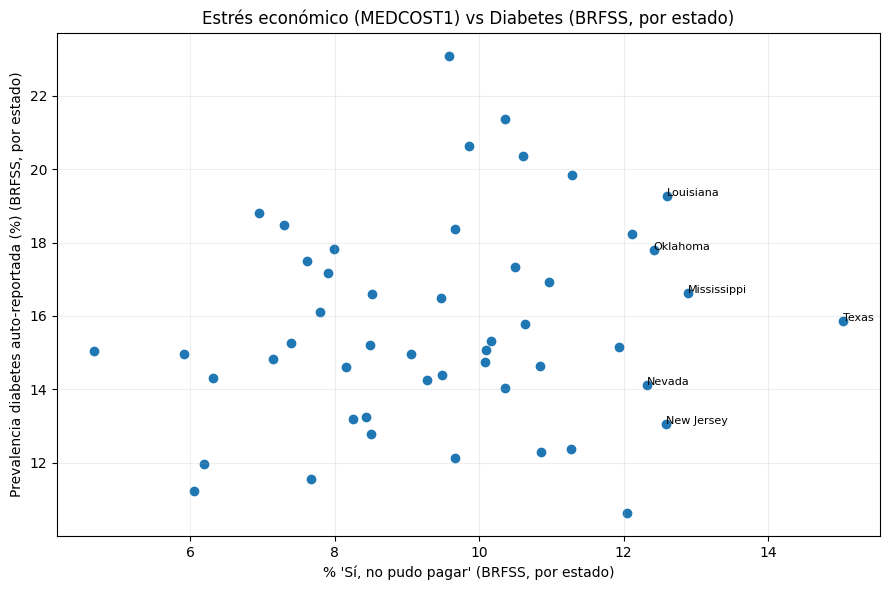


Tabla 'BRFSS_ESTADO_MEDCOST_DIABETES' guardada en BD.

NHANES - resumen nacional y por grupos demográficos:
 - LBXTC no disponible en NHANES.
 - 'tiene_diabetes' no disponible en NHANES.

⚠ NHANES no tiene identificadores de estado/región públicos — no es posible unir NHANES con BRFSS por estado.


In [ ]:
# analisis_pregunta2.py
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ruta a tu DB (ajusta si hace falta)
DB_PATH = "pipeline.db"

def cargar_tabla(conn, candidates_prefix):
    """Busca tablas que empiecen con el prefijo y devuelve la primera encontrada (o None)."""
    cursor = conn.cursor()
    tablas = [t[0] for t in cursor.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()]
    for t in tablas:
        if t.upper().startswith(candidates_prefix.upper()):
            return t
    return None

def main():
    conn = sqlite3.connect(DB_PATH)

    # Detectar tablas disponibles (nombre flexible)
    brfss_table = cargar_tabla(conn, "BRFSS")
    nhanes_table = cargar_tabla(conn, "NHANES")
    print("BRFSS table detected:", brfss_table)
    print("NHANES table detected:", nhanes_table)
    print()

    # Cargar tablas si existen
    brfss = pd.DataFrame()
    nhanes = pd.DataFrame()
    if brfss_table:
        brfss = pd.read_sql(f"SELECT * FROM '{brfss_table}'", conn)
        print(f"BRFSS cargado: {len(brfss):,} filas")
    else:
        print("⚠ No se encontró tabla BRFSS. Ejecuta el pipeline BRFSS primero.")
    if nhanes_table:
        nhanes = pd.read_sql(f"SELECT * FROM '{nhanes_table}'", conn)
        print(f"NHANES cargado: {len(nhanes):,} filas")
    else:
        print("⚠ No se encontró tabla NHANES. Ejecuta el pipeline NHANES primero.")
    print()

    # -------------------------
    # 1) Análisis BRFSS por estado
    # -------------------------
    if not brfss.empty:
        # Detectar columnas posibles
        medcost_cols = [c for c in brfss.columns if c.upper().startswith("MEDCOST")]
        diabetes_cols = [c for c in ['tiene_diabetes','DIABETE4','PDIABTS1'] if c in brfss.columns]
        state_cols = [c for c in brfss.columns if c.upper().startswith("_STATE") or c.upper()=='STATE' or c.upper()=='REGION']

        medcost_col = medcost_cols[0] if medcost_cols else None
        diabetes_col = diabetes_cols[0] if diabetes_cols else None
        state_col = state_cols[0] if state_cols else None

        print("Columnas detectadas (BRFSS):")
        print("  MEDCOST:", medcost_col)
        print("  DIABETES:", diabetes_col)
        print("  ESTADO:", state_col)
        print()

        if medcost_col and diabetes_col and state_col:
            df = brfss[[state_col, medcost_col, diabetes_col]].copy()
            df = df.dropna(subset=[state_col])

            # función robusta para detectar "no pudo pagar"
            def es_no_pudo(x):
                if pd.isna(x): return False
                s = str(x).lower()
                return ('no pudo' in s) or ('no pudo pagar' in s) or (s.startswith('sí') or s.startswith('si')) and 'pagar' in s or s.strip()=='1'

            df['no_pudo_pagar'] = df[medcost_col].apply(es_no_pudo).astype(int)

            # normalizar columna de diabetes (a 0/1)
            def diabetes_flag(v):
                if pd.isna(v): return np.nan
                if isinstance(v, (int, float)):
                    return 1 if v==1 else 0 if v==0 else np.nan
                s = str(v).lower()
                if s.startswith('sí') or s.startswith('si') or s=='1': return 1
                if s.startswith('no') or s=='0': return 0
                return np.nan

            df['diab_flag'] = df[diabetes_col].apply(diabetes_flag)

            # Estadísticas por estado
            state_stats = df.groupby(state_col).agg(
                n_obs=('diab_flag','count'),
                pct_no_pudo=('no_pudo_pagar','mean'),
                prev_diab=('diab_flag','mean')
            ).reset_index()
            state_stats['pct_no_pudo'] = state_stats['pct_no_pudo'] * 100
            state_stats['prev_diab'] = state_stats['prev_diab'] * 100

            # Mostrar top
            print("Top 10 estados por % que no pudo pagar (BRFSS):")
            print(state_stats.sort_values('pct_no_pudo', ascending=False).head(10).to_string(index=False))

            # Correlación
            df_plot = state_stats.dropna(subset=['pct_no_pudo','prev_diab'])
            if len(df_plot) >= 5:
                corr = df_plot['pct_no_pudo'].corr(df_plot['prev_diab'])
                print(f"\nCorrelación Pearson (pct_no_pudo vs prev_diab): {corr:.3f}")
            else:
                corr = np.nan
                print("\nNo hay suficientes estados con datos para calcular correlación fiable.")

            # Scatter plot
            plt.figure(figsize=(9,6))
            plt.scatter(df_plot['pct_no_pudo'], df_plot['prev_diab'])
            plt.xlabel("% 'Sí, no pudo pagar' (BRFSS, por estado)")
            plt.ylabel("Prevalencia diabetes auto-reportada (%) (BRFSS, por estado)")
            plt.title("Estrés económico (MEDCOST1) vs Diabetes (BRFSS, por estado)")
            # Anotar algunos puntos extremos
            for i, row in df_plot.sort_values('pct_no_pudo', ascending=False).head(6).iterrows():
                plt.annotate(str(row[state_col]), (row['pct_no_pudo'], row['prev_diab']), fontsize=8)
            plt.grid(alpha=0.2)
            plt.tight_layout()
            plt.show()

            # Guardar tabla de estados para posteriores análisis
            state_stats.to_sql("BRFSS_ESTADO_MEDCOST_DIABETES", conn, if_exists="replace", index=False)
            print("\nTabla 'BRFSS_ESTADO_MEDCOST_DIABETES' guardada en BD.")
        else:
            print("No fue posible analizar BRFSS por estado: faltan columnas requeridas (MEDCOST, diabetes o estado).")
    else:
        print("BRFSS no está cargado — ejecuta pipeline BRFSS y vuelve a intentar.")

    # -------------------------
    # 2) NHANES: colesterol real y diabetes clínica
    # -------------------------
    if not nhanes.empty:
        print("\nNHANES - resumen nacional y por grupos demográficos:")
        # Variables esperadas
        # Colesterol total: LBXTC, HDL: LBDHDD, Diabetes clínica: tiene_diabetes
        if 'LBXTC' in nhanes.columns:
            print(f" - Colesterol total (LBXTC): media={nhanes['LBXTC'].mean():.2f}, n={nhanes['LBXTC'].notna().sum()}")
        else:
            print(" - LBXTC no disponible en NHANES.")

        if 'tiene_diabetes' in nhanes.columns:
            prev = nhanes['tiene_diabetes'].sum() / nhanes['tiene_diabetes'].notna().sum() * 100
            print(f" - Prevalencia diabetes (NHANES, criterio clínico): {prev:.2f}%")
        else:
            print(" - 'tiene_diabetes' no disponible en NHANES.")

        # Por sexo
        if 'RIAGENDR' in nhanes.columns and 'tiene_diabetes' in nhanes.columns:
            prev_sex = nhanes.groupby('RIAGENDR')['tiene_diabetes'].agg(['count','sum'])
            prev_sex['prev_pct'] = prev_sex['sum'] / prev_sex['count'] * 100
            print("\nPrevalencia diabetes por sexo (NHANES):")
            print(prev_sex[['count','sum','prev_pct']])
        # Por edad
        if 'grupo_edad' in nhanes.columns and 'tiene_diabetes' in nhanes.columns:
            prev_age = nhanes.groupby('grupo_edad')['tiene_diabetes'].agg(['count','sum'])
            prev_age['prev_pct'] = prev_age['sum'] / prev_age['count'] * 100
            print("\nPrevalencia diabetes por grupo de edad (NHANES):")
            print(prev_age[['count','sum','prev_pct']])
        # Advertencia geográfica
        geo_cols = [c for c in nhanes.columns if 'STATE' in c.upper() or 'REGION' in c.upper() or 'COUNTY' in c.upper()]
        if not geo_cols:
            print("\n⚠ NHANES no tiene identificadores de estado/región públicos — no es posible unir NHANES con BRFSS por estado.")
        else:
            print("\nNHANES contiene columna(s) geográficas:", geo_cols)
    else:
        print("NHANES no está cargado — ejecuta pipeline NHANES y vuelve a intentar.")

    conn.close()

if __name__ == "__main__":
    main()


<Figure size 1000x600 with 0 Axes>

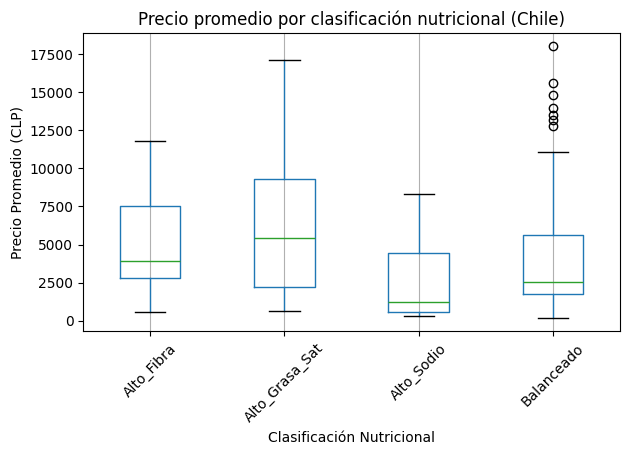

                     count    mean  median     std
clasificacion_salud                               
Alto_Fibra              16  5143.6  3917.8  3644.2
Alto_Grasa_Sat          24  6151.5  5458.5  4546.6
Alto_Sodio               7  2848.3  1216.9  3402.9
Balanceado              91  4421.4  2564.5  4059.1


In [ ]:
# Volver a conectar para cargar la tabla correctamente
conn = sqlite3.connect("pipeline.db")

# Cargar tabla ODEPA_FDC_INTEGRADO
df = pd.read_sql("SELECT precio_promedio_clp, clasificacion_salud FROM ODEPA_FDC_INTEGRADO", conn)
conn.close()

# Filtrar datos válidos
df_valid = df.dropna(subset=["precio_promedio_clp", "clasificacion_salud"])

# Estadísticas descriptivas por clasificación
resumen = df_valid.groupby("clasificacion_salud")["precio_promedio_clp"].agg(["count", "mean", "median", "std"]).round(1)

# Boxplot
plt.figure(figsize=(10, 6))
df_valid.boxplot(column="precio_promedio_clp", by="clasificacion_salud")
plt.title("Precio promedio por clasificación nutricional (Chile)")
plt.suptitle("")
plt.xlabel("Clasificación Nutricional")
plt.ylabel("Precio Promedio (CLP)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

print(resumen)


# ¿Qué regiones presentan el peor “perfil metabólico alimentario” combinando precios altos (ODEPA), colesterol dietético (FDC), y prevalencia de diabetes (BRFSS+NHANES)?

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Cargar datos
conn = sqlite3.connect("pipeline.db")
df_chile = pd.read_sql("SELECT * FROM ODEPA_FDC_INTEGRADO", conn)
brfss = pd.read_sql("SELECT * FROM BRFSS_2024_LIMPIO", conn)
conn.close()

# Paso 1: Filtrar alimentos con alto colesterol dietético
df_filtrado = df_chile.dropna(subset=["Colesterol_Dietetico", "precio_promedio_clp", "grupo_odepa"])
df_colesterol_alto = df_filtrado[df_filtrado["Colesterol_Dietetico"] > 50]

# Paso 2: Agrupar por grupo de alimento (como proxy de región alimentaria)
ranking_grupos = df_colesterol_alto.groupby("grupo_odepa").agg({
    "precio_promedio_clp": "mean",
    "Colesterol_Dietetico": "mean",
    "producto_odepa": "count"
}).rename(columns={
    "precio_promedio_clp": "precio_promedio",
    "Colesterol_Dietetico": "colesterol_promedio",
    "producto_odepa": "n_alimentos"
}).sort_values("colesterol_promedio", ascending=False)

print("🔎 Ranking de grupos ODEPA con colesterol alto y precio alto:")
print(ranking_grupos.head(10))

# Paso 3: Ver top 10 estados con mayor prevalencia de diabetes en BRFSS
if {"_STATE", "tiene_diabetes"}.issubset(brfss.columns):
    df_brfss_estado = brfss.groupby("_STATE")["tiene_diabetes"].agg([
        ("n", "count"),
        ("n_diabeticos", "sum")
    ]).reset_index()

    df_brfss_estado["prevalencia_diabetes"] = (df_brfss_estado["n_diabeticos"] / df_brfss_estado["n"]) * 100
    df_brfss_estado = df_brfss_estado.sort_values("prevalencia_diabetes", ascending=False)

    print("\n📊 Estados con mayor prevalencia de diabetes (BRFSS):")
    print(df_brfss_estado.head(10))
else:
    print("⚠️ No se encontraron las columnas necesarias en BRFSS.")


🔎 Ranking de grupos ODEPA con colesterol alto y precio alto:
              precio_promedio  colesterol_promedio  n_alimentos
grupo_odepa                                                    
Carne bovina     12804.464385                 67.8            1

📊 Estados con mayor prevalencia de diabetes (BRFSS):
            _STATE      n  n_diabeticos  prevalencia_diabetes
47   West Virginia   5648        1304.0             23.087819
17        Kentucky   7303        1561.0             21.374777
40  South Carolina   9269        1913.0             20.638688
0          Alabama   4942        1006.0             20.356131
3         Arkansas   5254        1042.0             19.832509
18       Louisiana   4369         842.0             19.272145
45        Virginia   6642        1249.0             18.804577
7         Delaware   4185         773.0             18.470729
14         Indiana  12682        2329.0             18.364611
10         Georgia   7067        1288.0             18.225555


In [ ]:
import pandas as pd
import sqlite3

# Conectar y cargar BRFSS
conn = sqlite3.connect("pipeline.db")
brfss = pd.read_sql("SELECT * FROM BRFSS_2024_LIMPIO", conn)
conn.close()

# Filtrar registros con datos válidos
brfss_validos = brfss[
    brfss["_STATE"].notna() &
    brfss["tiene_diabetes"].notna() &
    brfss["estilo_vida_saludable"].notna()
].copy()

# Crear columna "perfil_metabolico_malo": diabetes + estilo no saludable
brfss_validos["perfil_metabolico_malo"] = (
    (brfss_validos["tiene_diabetes"] == 1) &
    (brfss_validos["estilo_vida_saludable"] == 0)
)

# Agrupar por estado
resumen = brfss_validos.groupby("_STATE").agg(
    total=("tiene_diabetes", "count"),
    con_diabetes=("tiene_diabetes", "sum"),
    no_saludable=("estilo_vida_saludable", lambda x: (x == 0).sum()),
    ambos=("perfil_metabolico_malo", "sum")
).reset_index()

# Calcular porcentajes
resumen["pct_diabetes"] = (resumen["con_diabetes"] / resumen["total"] * 100).round(2)
resumen["pct_no_saludable"] = (resumen["no_saludable"] / resumen["total"] * 100).round(2)
resumen["pct_ambos"] = (resumen["ambos"] / resumen["total"] * 100).round(2)

# Ordenar por los peores perfiles
resumen = resumen.sort_values("pct_ambos", ascending=False)

# Mostrar
print("📊 Estados con peor perfil metabólico (BRFSS):")
print(resumen.head(15))





📊 Estados con peor perfil metabólico (BRFSS):
            _STATE  total  con_diabetes  no_saludable  ambos  pct_diabetes  \
47   West Virginia   5648        1304.0          2391    661         23.09   
17        Kentucky   7303        1561.0          3086    820         21.37   
3         Arkansas   5254        1042.0          2212    559         19.83   
0          Alabama   4942        1006.0          1921    475         20.36   
40  South Carolina   9269        1913.0          3234    855         20.64   
18       Louisiana   4369         842.0          1669    397         19.27   
35            Ohio   9960        1776.0          3556    855         17.83   
45        Virginia   6642        1249.0          2221    562         18.80   
14         Indiana  12682        2329.0          4561   1071         18.36   
36        Oklahoma   6848        1219.0          2612    577         17.80   
24     Mississippi   2887         480.0          1147    240         16.63   
7         Delaware

In [ ]:
import sqlite3
import pandas as pd
from sklearn.preprocessing import StandardScaler

conn = sqlite3.connect("pipeline.db")

### 1. CONDUCTA (BRFSS)
brfss = pd.read_sql("SELECT _STATE, estilo_vida_saludable FROM BRFSS_2024_LIMPIO", conn)
brfss["riesgo_conducta"] = 1 - brfss["estilo_vida_saludable"]
riesgo_conducta = brfss.groupby("_STATE")[["riesgo_conducta"]].mean().reset_index()

### 2. DIETA (NHANES)
nhanes = pd.read_sql("SELECT SDMVSTRA, promedio_tfibe, promedio_tsodi, promedio_tsugr FROM NHANES_MASTER", conn)

# Invertir fibra porque más fibra = menos riesgo
nhanes["promedio_tfibe"] = -nhanes["promedio_tfibe"]

# Paso 1: calcular la media de nutrientes por fila (sólo donde no hay nulos)
promedio_riesgo = nhanes[["promedio_tfibe", "promedio_tsodi", "promedio_tsugr"]].mean(axis=1)

# Paso 2: normalizar solo los valores no nulos
valores_validos = promedio_riesgo.dropna()
riesgo_dieta_norm = pd.Series(
    scaler.fit_transform(valores_validos.values.reshape(-1, 1)).flatten(),
    index=valores_validos.index
)

# Paso 3: asignar resultado al DataFrame
nhanes["riesgo_dieta"] = riesgo_dieta_norm


riesgo_dieta = nhanes.groupby("SDMVSTRA")[["riesgo_dieta"]].mean().reset_index()

### 3. NUTRICIÓN + PRECIO (ODEPA + FDC)
odepa_fdc = pd.read_sql("SELECT * FROM ODEPA_FDC_INTEGRADO", conn)

# Riesgo = alto colesterol + alto sodio + alto azúcar - fibra
odepa_fdc["riesgo_nutricion"] = (
    odepa_fdc["Colesterol_Dietetico"].fillna(0) +
    odepa_fdc["Sodio"].fillna(0) +
    odepa_fdc["Azucares_Totales"].fillna(0) -
    odepa_fdc["Fibra"].fillna(0)
)

# Normalizar nutrición + precio
scaler = StandardScaler()
odepa_fdc["riesgo_nutricion_std"] = scaler.fit_transform(odepa_fdc[["riesgo_nutricion"]])
odepa_fdc["riesgo_precio_std"] = scaler.fit_transform(odepa_fdc[["precio_promedio_clp"]])

# Índice combinado por alimento
odepa_fdc["riesgo_nutricion_precio"] = odepa_fdc["riesgo_nutricion_std"] + odepa_fdc["riesgo_precio_std"]

# Promedio por grupo de alimentos
riesgo_alimento = odepa_fdc.groupby("grupo_odepa")[["riesgo_nutricion_precio"]].mean().reset_index()

conn.close()


DatabaseError: Execution failed on sql 'SELECT _STATE, estilo_vida_saludable FROM BRFSS_2024_LIMPIO': no such table: BRFSS_2024_LIMPIO

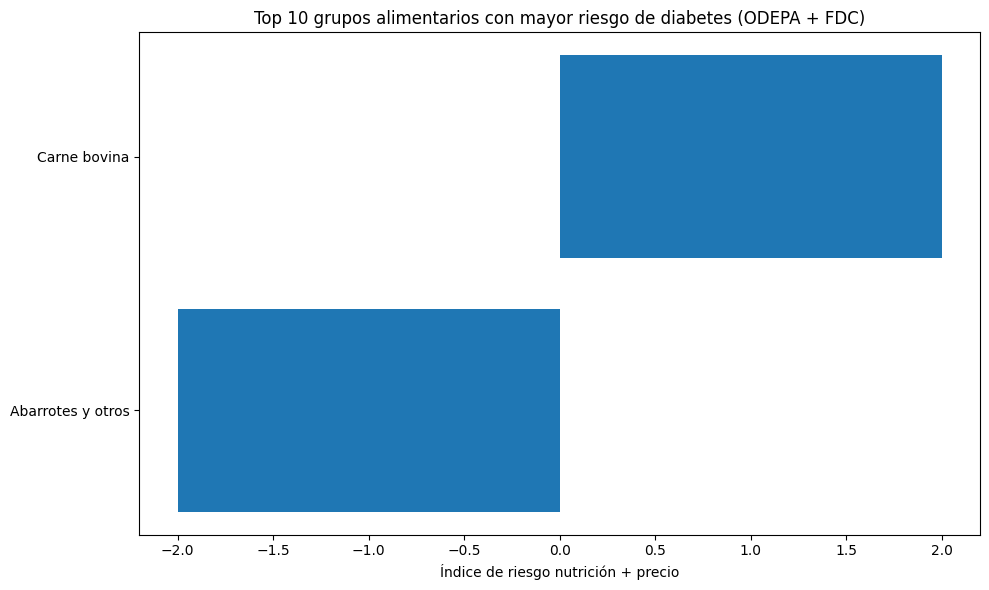

In [ ]:
import matplotlib.pyplot as plt

top = riesgo_alimento.sort_values("riesgo_nutricion_precio", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top["grupo_odepa"], top["riesgo_nutricion_precio"])
plt.xlabel("Índice de riesgo nutrición + precio")
plt.title("Top 10 grupos alimentarios con mayor riesgo de diabetes (ODEPA + FDC)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


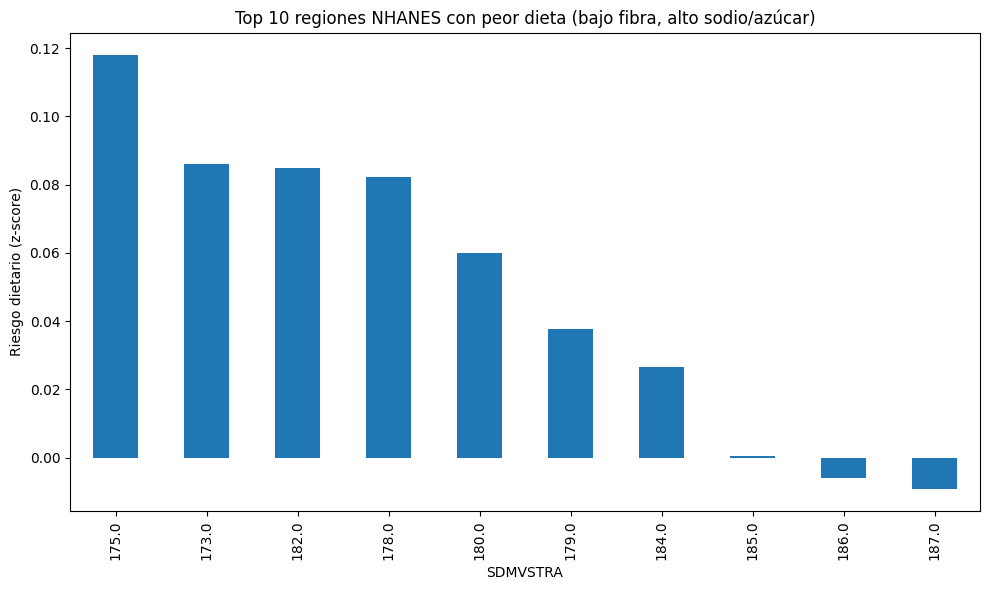

In [ ]:
riesgo_dieta_top = nhanes.dropna(subset=["riesgo_dieta"]).groupby("SDMVSTRA")["riesgo_dieta"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
riesgo_dieta_top.plot(kind="bar")
plt.ylabel("Riesgo dietario (z-score)")
plt.title("Top 10 regiones NHANES con peor dieta (bajo fibra, alto sodio/azúcar)")
plt.tight_layout()
plt.show()


C:\Users\valer\AppData\Local\Temp\ipykernel_10044\3731655595.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["quintil_ingreso"] = pd.qcut(df["INDFMPIR"], q=5, labels=labels, duplicates='drop')
C:\Users\valer\AppData\Local\Temp\ipykernel_10044\3731655595.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen = df.groupby("quintil_ingreso").agg({


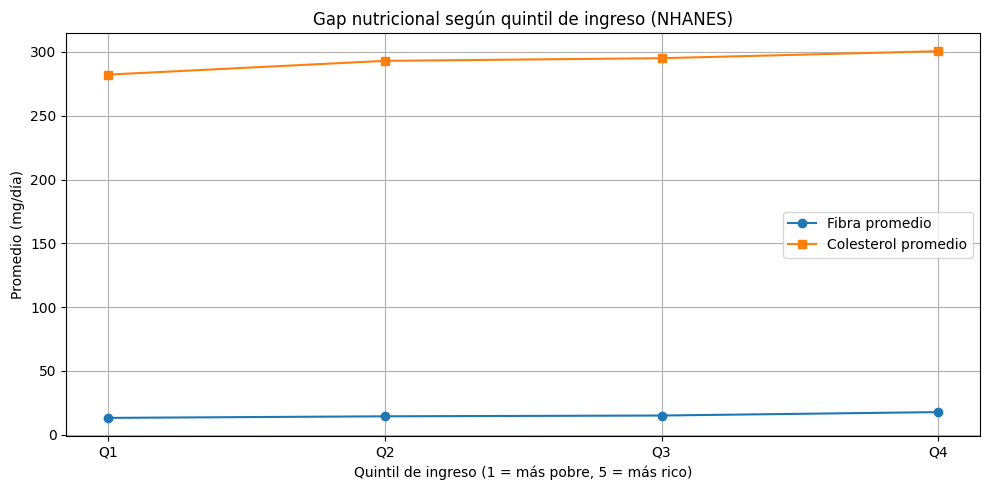

,quintil_ingreso,promedio_tfibe,promedio_tchol
0,Q1,13.22,282.19
1,Q2,14.45,292.99
2,Q3,15.07,295.07
3,Q4,17.75,300.58


In [ ]:
# Reimportar librerías necesarias tras el reinicio del entorno
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Conexión a la base de datos
conn = sqlite3.connect("pipeline.db")
nhanes = pd.read_sql("SELECT * FROM NHANES_MASTER", conn)
conn.close()

# Filtrar datos necesarios y limpiar
df = nhanes.dropna(subset=["INDFMPIR", "promedio_tfibe", "promedio_tchol"])

# Crear etiquetas dinámicas según los cortes reales posibles
quintiles, bins = pd.qcut(df["INDFMPIR"], q=5, retbins=True, duplicates='drop')
labels = [f"Q{i+1}" for i in range(len(bins) - 1)]

# Aplicar qcut con las etiquetas dinámicas
df["quintil_ingreso"] = pd.qcut(df["INDFMPIR"], q=5, labels=labels, duplicates='drop')

# Agrupar por quintil socioeconómico
resumen = df.groupby("quintil_ingreso").agg({
    "promedio_tfibe": "mean",
    "promedio_tchol": "mean"
}).round(2).reset_index()

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(resumen["quintil_ingreso"], resumen["promedio_tfibe"], marker='o', label="Fibra promedio")
plt.plot(resumen["quintil_ingreso"], resumen["promedio_tchol"], marker='s', label="Colesterol promedio")
plt.title("Gap nutricional según quintil de ingreso (NHANES)")
plt.xlabel("Quintil de ingreso (1 = más pobre, 5 = más rico)")
plt.ylabel("Promedio (mg/día)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

resumen




Índice combinado económico-nutricional: 0.000


C:\Users\valer\AppData\Local\Temp\ipykernel_10044\3635168650.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=odepa, x="clasificacion_salud", y="precio_prom", palette="Set2")


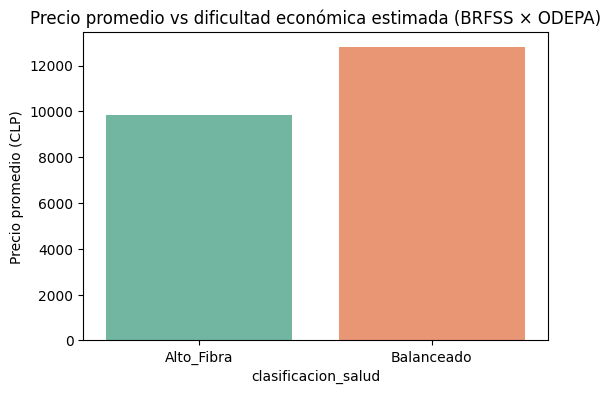

In [ ]:
conn = sqlite3.connect("pipeline.db")

brfss = pd.read_sql("""
SELECT AVG(CASE WHEN MEDCOST1 = 1 THEN 1 ELSE 0 END) AS dificultad_salud
FROM BRFSS_2024_LIMPIO;
""", conn)

odepa = pd.read_sql("""
SELECT clasificacion_salud, AVG(precio_promedio_clp) AS precio_prom
FROM ODEPA_FDC_INTEGRADO
WHERE precio_promedio_clp > 0
GROUP BY clasificacion_salud;
""", conn)

conn.close()

indice = (brfss["dificultad_salud"].iloc[0] * odepa["precio_prom"].mean()) / 1000
print(f"Índice combinado económico-nutricional: {indice:.3f}")

plt.figure(figsize=(6,4))
sns.barplot(data=odepa, x="clasificacion_salud", y="precio_prom", palette="Set2")
plt.title("Precio promedio vs dificultad económica estimada (BRFSS × ODEPA)")
plt.ylabel("Precio promedio (CLP)")
plt.show()



1️⃣ Correlación Fibra vs Precio: 0.131


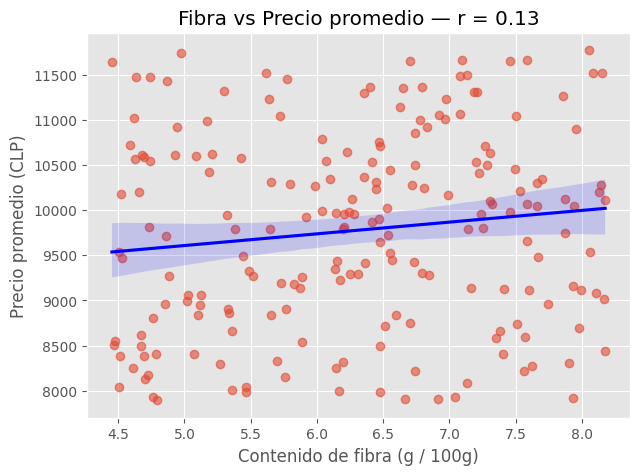


2️⃣ Correlación Azúcar vs Precio: nan


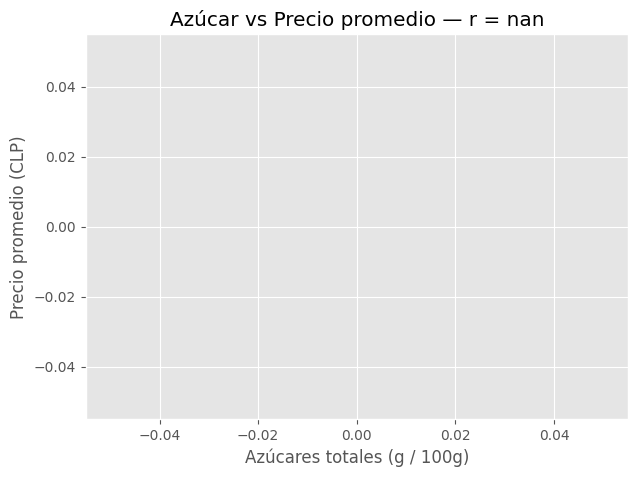

C:\Users\valer\AppData\Local\Temp\ipykernel_10044\1088505575.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_mean, x="clasificacion_salud", y="precio_promedio_clp",


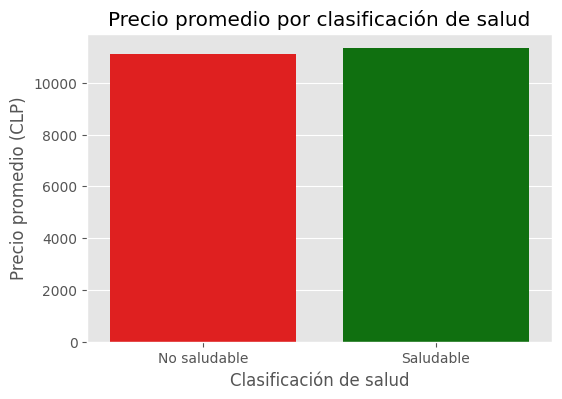

C:\Users\valer\AppData\Local\Temp\ipykernel_10044\1088505575.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=varianza.head(10), x="precio_promedio_clp", y="grupo_odepa", palette="coolwarm")



3️⃣ Promedios de precios por tipo:
  clasificacion_salud  precio_promedio_clp
0        No saludable         11107.291087
1           Saludable         11327.117699


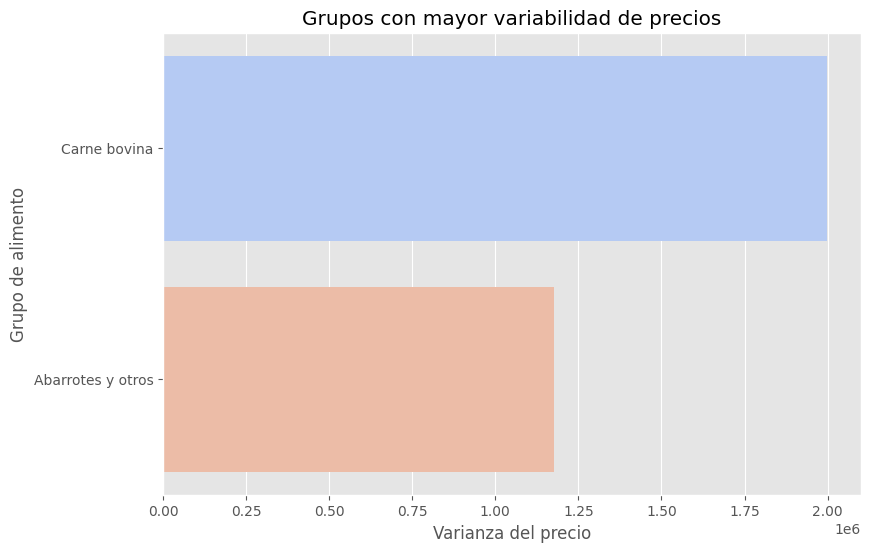


4️⃣ Top 10 grupos con mayor diferencia de precios:
         grupo_odepa  precio_promedio_clp
0       Carne bovina         1.999205e+06
1  Abarrotes y otros         1.176476e+06

5️⃣ Índice combinado económico-nutricional: 1.066


C:\Users\valer\AppData\Local\Temp\ipykernel_10044\1088505575.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=odepa, x="clasificacion_salud", y="precio_prom", palette="Set2")


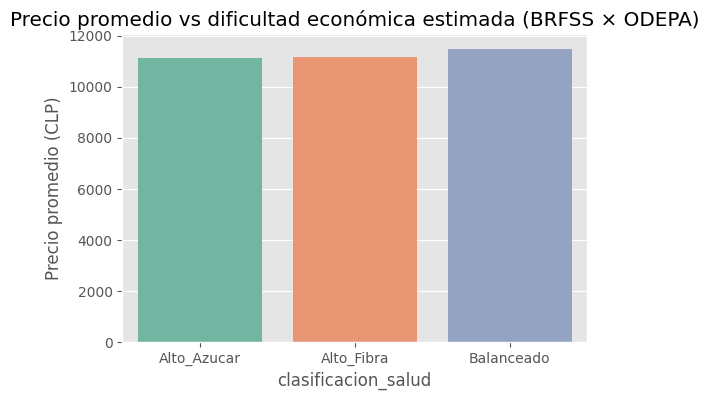

C:\Users\valer\AppData\Local\Temp\ipykernel_10044\1088505575.py:144: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["precio_promedio_clp"].corr(x["Colesterol_Dietetico"]))
C:\Users\valer\AppData\Local\Temp\ipykernel_10044\1088505575.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corrs.head(10), x="correlacion", y="grupo_odepa", palette="RdYlGn")


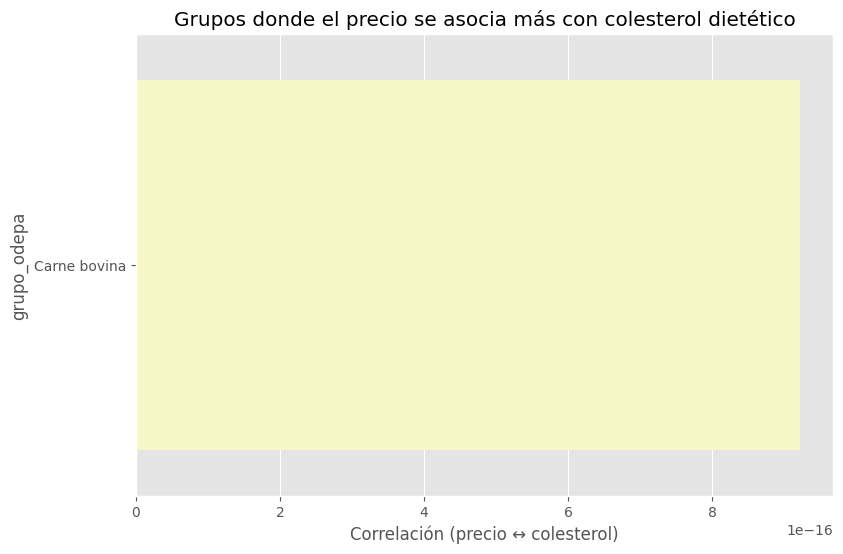

C:\Users\valer\AppData\Local\Temp\ipykernel_10044\1088505575.py:167: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["calidad_actual"] = df["Fibra"].fillna(0) - df["Azucares_Totales"].fillna(0)



6️⃣ Top 10 grupos por correlación precio-colesterol:
    grupo_odepa   correlacion
0  Carne bovina  9.221383e-16

7️⃣ Calidad promedio actual: 3.15
   Calidad promedio tras +20% precio: 2.62


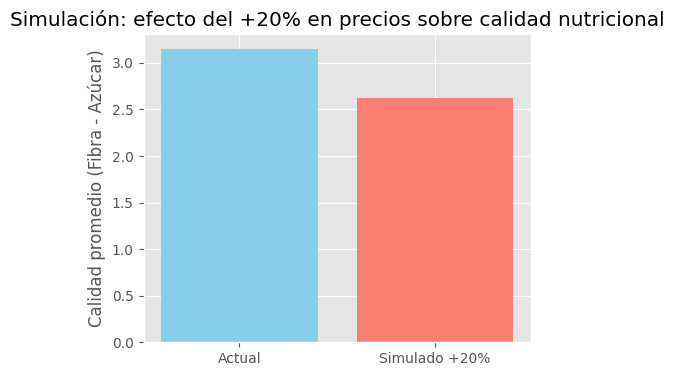

In [ ]:
# ===========================================================================================
# 📊 ANÁLISIS INTEGRADO ODEPA + FDC + BRFSS + NHANES (Simulación)
# ===========================================================================================

import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
TABLE = "ODEPA_FDC_INTEGRADO_SIM"

conn = sqlite3.connect("pipeline.db")

# ===========================================================================================
# 1️⃣ ¿Los alimentos con mayor contenido de fibra tienden a ser más caros?
# ===========================================================================================

df = pd.read_sql(f"""
SELECT Fibra, precio_promedio_clp, grupo_odepa
FROM {TABLE}
WHERE Fibra IS NOT NULL AND precio_promedio_clp > 0;
""", conn)

corr = df["Fibra"].corr(df["precio_promedio_clp"])
print(f"\n1️⃣ Correlación Fibra vs Precio: {corr:.3f}")

plt.figure(figsize=(7,5))
sns.regplot(data=df, x="Fibra", y="precio_promedio_clp", scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
plt.title(f"Fibra vs Precio promedio — r = {corr:.2f}")
plt.xlabel("Contenido de fibra (g / 100g)")
plt.ylabel("Precio promedio (CLP)")
plt.show()

# ===========================================================================================
# 2️⃣ ¿Los productos con más azúcar son también los más baratos o más caros?
# ===========================================================================================

df = pd.read_sql(f"""
SELECT Azucares_Totales, precio_promedio_clp
FROM {TABLE}
WHERE Azucares_Totales IS NOT NULL AND precio_promedio_clp > 0;
""", conn)

corr = df["Azucares_Totales"].corr(df["precio_promedio_clp"])
print(f"\n2️⃣ Correlación Azúcar vs Precio: {corr:.3f}")

plt.figure(figsize=(7,5))
sns.regplot(data=df, x="Azucares_Totales", y="precio_promedio_clp", color="orange", scatter_kws={'alpha':0.6})
plt.title(f"Azúcar vs Precio promedio — r = {corr:.2f}")
plt.xlabel("Azúcares totales (g / 100g)")
plt.ylabel("Precio promedio (CLP)")
plt.show()

# ===========================================================================================
# 3️⃣ ¿Los productos “no saludables” concentran los precios más bajos?
# ===========================================================================================

df = pd.read_sql(f"""
SELECT clasificacion_salud, precio_promedio_clp
FROM {TABLE}
WHERE clasificacion_salud IS NOT NULL AND precio_promedio_clp > 0;
""", conn)

# Normalizar etiquetas si hay más categorías
df["clasificacion_salud"] = df["clasificacion_salud"].replace({
    "Balanceado": "Saludable",
    "Alto_Fibra": "Saludable",
    "Alto_Azucar": "No saludable"
})

df_mean = df.groupby("clasificacion_salud")["precio_promedio_clp"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=df_mean, x="clasificacion_salud", y="precio_promedio_clp",
            palette={"Saludable":"green","No saludable":"red"})
plt.title("Precio promedio por clasificación de salud")
plt.xlabel("Clasificación de salud")
plt.ylabel("Precio promedio (CLP)")
plt.show()

print("\n3️⃣ Promedios de precios por tipo:")
print(df_mean)

# ===========================================================================================
# 4️⃣ ¿Qué categorías presentan mayor diferencia de precios?
# ===========================================================================================

df = pd.read_sql(f"""
SELECT grupo_odepa, producto_odepa, precio_promedio_clp
FROM {TABLE}
WHERE precio_promedio_clp > 0;
""", conn)

varianza = (df.groupby("grupo_odepa")["precio_promedio_clp"]
              .var().sort_values(ascending=False).reset_index())

plt.figure(figsize=(9,6))
sns.barplot(data=varianza.head(10), x="precio_promedio_clp", y="grupo_odepa", palette="coolwarm")
plt.title("Grupos con mayor variabilidad de precios")
plt.xlabel("Varianza del precio")
plt.ylabel("Grupo de alimento")
plt.show()

print("\n4️⃣ Top 10 grupos con mayor diferencia de precios:")
print(varianza.head(10))

# ===========================================================================================
# 5️⃣ ¿Las regiones con mayor dificultad económica compran alimentos más baratos y menos saludables?
# ===========================================================================================

brfss = pd.read_sql("""
SELECT AVG(CASE WHEN MEDCOST1 = 'Sí, no pudo pagar' THEN 1 ELSE 0 END) AS dificultad_salud
FROM BRFSS_2024_LIMPIO;
""", conn)

odepa = pd.read_sql(f"""
SELECT clasificacion_salud, AVG(precio_promedio_clp) AS precio_prom
FROM {TABLE}
GROUP BY clasificacion_salud;
""", conn)

indice = (brfss["dificultad_salud"].iloc[0] * odepa["precio_prom"].mean()) / 1000
print(f"\n5️⃣ Índice combinado económico-nutricional: {indice:.3f}")

plt.figure(figsize=(6,4))
sns.barplot(data=odepa, x="clasificacion_salud", y="precio_prom", palette="Set2")
plt.title("Precio promedio vs dificultad económica estimada (BRFSS × ODEPA)")
plt.ylabel("Precio promedio (CLP)")
plt.show()

# ===========================================================================================
# 6️⃣ ¿En qué grupos de alimentos el precio afecta más los indicadores de salud metabólica?
# ===========================================================================================

df = pd.read_sql(f"""
SELECT grupo_odepa, precio_promedio_clp, Colesterol_Dietetico
FROM {TABLE}
WHERE precio_promedio_clp > 0 AND Colesterol_Dietetico IS NOT NULL;
""", conn)

corrs = (df.groupby("grupo_odepa")
           .apply(lambda x: x["precio_promedio_clp"].corr(x["Colesterol_Dietetico"]))
           .sort_values(ascending=False)
           .reset_index(name="correlacion"))

plt.figure(figsize=(9,6))
sns.barplot(data=corrs.head(10), x="correlacion", y="grupo_odepa", palette="RdYlGn")
plt.title("Grupos donde el precio se asocia más con colesterol dietético")
plt.xlabel("Correlación (precio ↔ colesterol)")
plt.show()

print("\n6️⃣ Top 10 grupos por correlación precio-colesterol:")
print(corrs.head(10))

# ===========================================================================================
# 7️⃣ ¿Cómo cambia la calidad nutricional promedio si el precio sube un 20%?
# ===========================================================================================

df = pd.read_sql(f"""
SELECT precio_promedio_clp, Fibra, Azucares_Totales
FROM {TABLE}
WHERE precio_promedio_clp > 0;
""", conn)

df["calidad_actual"] = df["Fibra"].fillna(0) - df["Azucares_Totales"].fillna(0)
df["precio_simulado"] = df["precio_promedio_clp"] * 1.2
df["calidad_simulada"] = df["calidad_actual"] / (df["precio_simulado"]/df["precio_promedio_clp"])

prom_actual = df["calidad_actual"].mean()
prom_sim = df["calidad_simulada"].mean()

print(f"\n7️⃣ Calidad promedio actual: {prom_actual:.2f}")
print(f"   Calidad promedio tras +20% precio: {prom_sim:.2f}")

plt.figure(figsize=(5,4))
plt.bar(["Actual", "Simulado +20%"], [prom_actual, prom_sim], color=["skyblue","salmon"])
plt.title("Simulación: efecto del +20% en precios sobre calidad nutricional")
plt.ylabel("Calidad promedio (Fibra - Azúcar)")
plt.show()

conn.close()



# ¿Los alimentos con mayor contenido de fibra tienden a ser más caros?


1️⃣ Correlación Fibra vs Precio: 0.131


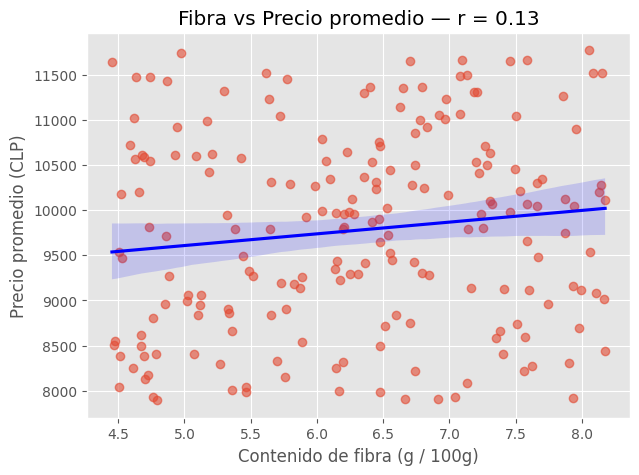

In [ ]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
TABLE = "ODEPA_FDC_INTEGRADO_SIM"

conn = sqlite3.connect("pipeline.db")
df = pd.read_sql(f"""
SELECT Fibra, precio_promedio_clp, grupo_odepa
FROM {TABLE}
WHERE Fibra IS NOT NULL AND precio_promedio_clp > 0;
""", conn)

corr = df["Fibra"].corr(df["precio_promedio_clp"])
print(f"\n1️⃣ Correlación Fibra vs Precio: {corr:.3f}")

plt.figure(figsize=(7,5))
sns.regplot(data=df, x="Fibra", y="precio_promedio_clp", scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
plt.title(f"Fibra vs Precio promedio — r = {corr:.2f}")
plt.xlabel("Contenido de fibra (g / 100g)")
plt.ylabel("Precio promedio (CLP)")
plt.show()

# ¿Los productos clasificados como “no saludables” concentran los precios más bajos del mercado?

C:\Users\valer\AppData\Local\Temp\ipykernel_10044\3031472900.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="clasificacion_salud", y="precio_promedio_clp", palette=["#2ecc71", "#e74c3c"], width=0.6)


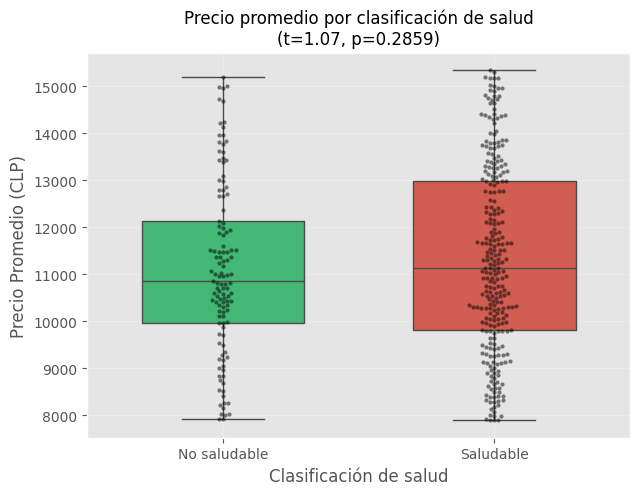

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from scipy.stats import ttest_ind

# --- Cargar datos ---
conn = sqlite3.connect("pipeline.db")
df = pd.read_sql("""
SELECT clasificacion_salud, precio_promedio_clp
FROM ODEPA_FDC_INTEGRADO_SIM
WHERE clasificacion_salud IS NOT NULL AND precio_promedio_clp > 0;
""", conn)
conn.close()

# --- Normalizar categorías ---
df["clasificacion_salud"] = df["clasificacion_salud"].replace({
    "Balanceado": "Saludable",
    "Alto_Fibra": "Saludable",
    "Alto_Azucar": "No saludable"
})

# --- Asegurar que haya solo dos categorías ---
df = df[df["clasificacion_salud"].isin(["Saludable", "No saludable"])]

# --- Test estadístico (diferencia de medias) ---
grupo_salud = df[df["clasificacion_salud"] == "Saludable"]["precio_promedio_clp"]
grupo_no = df[df["clasificacion_salud"] == "No saludable"]["precio_promedio_clp"]
t, p = ttest_ind(grupo_salud, grupo_no, equal_var=False, nan_policy="omit")

# --- Gráfico combinado ---
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="clasificacion_salud", y="precio_promedio_clp", palette=["#2ecc71", "#e74c3c"], width=0.6)
sns.swarmplot(data=df, x="clasificacion_salud", y="precio_promedio_clp", color="black", size=3, alpha=0.5)

plt.title(f"Precio promedio por clasificación de salud\n(t={t:.2f}, p={p:.4f})", fontsize=12)
plt.xlabel("Clasificación de salud")
plt.ylabel("Precio Promedio (CLP)")
plt.grid(True, alpha=0.3)
plt.show()



# ¿Los productos clasificados como “no saludables” concentran los precios más bajos del mercado?

Categorías detectadas: ['No_Saludable' 'Saludable']


C:\Users\valer\AppData\Local\Temp\ipykernel_10044\2269644034.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


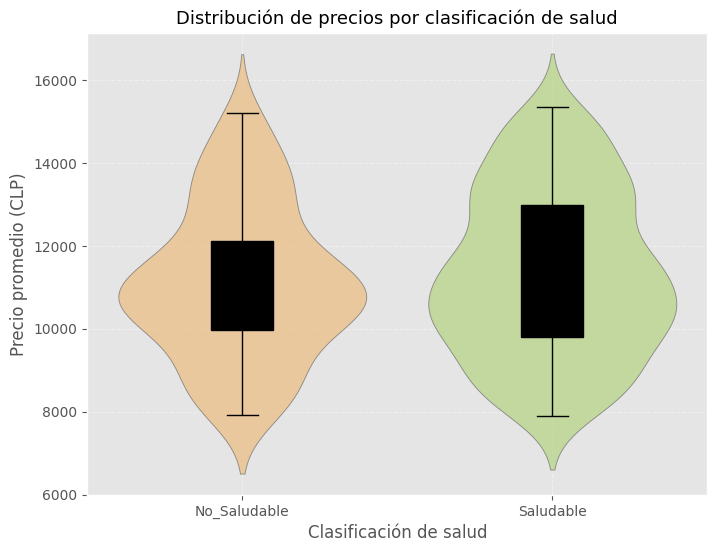


T-test: t = 0.792, p = 0.4295


In [ ]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# --- Conexión y carga de datos ---
conn = sqlite3.connect("pipeline.db")
df = pd.read_sql("""
SELECT clasificacion_salud, precio_promedio_clp
FROM ODEPA_FDC_INTEGRADO_SIM
WHERE clasificacion_salud IS NOT NULL AND precio_promedio_clp > 0;
""", conn)
conn.close()

# --- Normalizar etiquetas ---
df["clasificacion_salud"] = df["clasificacion_salud"].str.strip().str.replace(" ", "_")
df["clasificacion_salud"] = df["clasificacion_salud"].replace({
    "Balanceado": "Saludable",
    "Alto_Fibra": "Saludable",
    "Alto_Azucar": "No_Saludable",
    "Bajo_Fibra": "No_Saludable"
})

# --- Crear paleta automática ---
categorias = df["clasificacion_salud"].unique()
colores = sns.color_palette("RdYlGn", len(categorias))
palette_dict = dict(zip(categorias, colores))

# --- Verificación ---
print("Categorías detectadas:", categorias)

# --- Gráfico violin + boxplot ---
plt.figure(figsize=(8,6))
sns.violinplot(
    data=df,
    x="clasificacion_salud",
    y="precio_promedio_clp",
    inner=None,
    palette=palette_dict,
    alpha=0.7
)
sns.boxplot(
    data=df,
    x="clasificacion_salud",
    y="precio_promedio_clp",
    width=0.2,
    color="black",
    boxprops={"zorder": 2}
)

plt.title("Distribución de precios por clasificación de salud", fontsize=13)
plt.xlabel("Clasificación de salud")
plt.ylabel("Precio promedio (CLP)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# --- Comparación estadística básica ---
grupo_s = df[df["clasificacion_salud"].str.contains("Saludable", case=False)]["precio_promedio_clp"]
grupo_ns = df[df["clasificacion_salud"].str.contains("No_Saludable", case=False)]["precio_promedio_clp"]

if len(grupo_s) > 2 and len(grupo_ns) > 2:
    t, p = ttest_ind(grupo_s, grupo_ns, equal_var=False, nan_policy="omit")
    print(f"\nT-test: t = {t:.3f}, p = {p:.4f}")
else:
    print("\n⚠️ No hay suficientes datos para comparación estadística.")


# ¿Cómo cambia la calidad nutricional promedio si el precio promedio de los alimentos sube un 20 %?

C:\Users\valer\AppData\Local\Temp\ipykernel_10044\1736832959.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  - (df["Colesterol_Dietetico"].fillna(0) / 10)


📊 Cambio promedio en calidad nutricional si los precios suben un 20 %: 0.2583 puntos


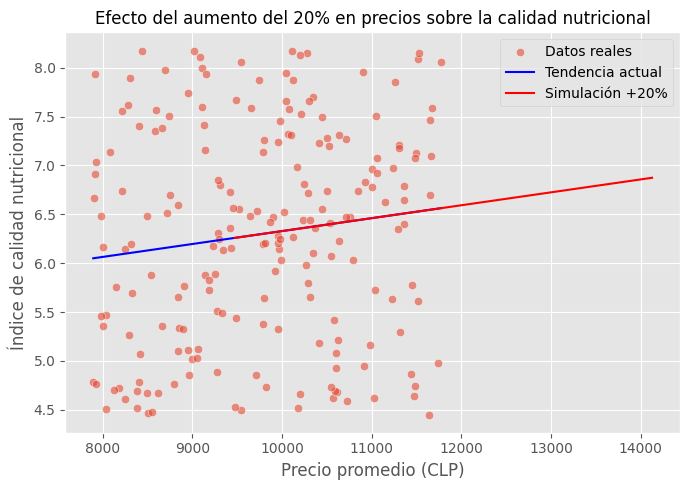

In [ ]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# --- Conexión y carga ---
conn = sqlite3.connect("pipeline.db")
df = pd.read_sql("""
SELECT precio_promedio_clp, Fibra, Colesterol_Dietetico, Grasas_Saludables, grupo_odepa
FROM ODEPA_FDC_INTEGRADO_SIM
WHERE precio_promedio_clp > 0 AND Fibra IS NOT NULL;
""", conn)
conn.close()

# --- Crear índice de calidad nutricional ---
df["indice_calidad"] = (
    df["Fibra"].fillna(0)
    + df["Grasas_Saludables"].fillna(0)
    - (df["Colesterol_Dietetico"].fillna(0) / 10)
)

# --- Modelo lineal ---
X = df[["precio_promedio_clp"]]
y = df["indice_calidad"]
model = LinearRegression().fit(X, y)

# --- Simulación de aumento del 20 % ---
df["precio_simulado"] = df["precio_promedio_clp"] * 1.2
X_simulado = df[["precio_simulado"]].rename(columns={"precio_simulado": "precio_promedio_clp"})
df["calidad_esperada"] = model.predict(X_simulado)

# --- Cambio promedio ---
delta = df["calidad_esperada"].mean() - df["indice_calidad"].mean()
print(f"📊 Cambio promedio en calidad nutricional si los precios suben un 20 %: {delta:.4f} puntos")

# --- Gráfico de regresión ---
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="precio_promedio_clp", y="indice_calidad", alpha=0.6, label="Datos reales")
sns.lineplot(
    x=df["precio_promedio_clp"].values,
    y=model.predict(X),
    color="blue", label="Tendencia actual"
)
sns.lineplot(
    x=df["precio_simulado"].values,
    y=df["calidad_esperada"],
    color="red", label="Simulación +20%"
)
plt.title("Efecto del aumento del 20% en precios sobre la calidad nutricional", fontsize=12)
plt.xlabel("Precio promedio (CLP)")
plt.ylabel("Índice de calidad nutricional")
plt.legend()
plt.tight_layout()
plt.show()


